In [1]:
import xarray as xr
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from data.utils import load_training_datasets

# Load ground truth for offline

In [2]:
raw_data = xr.open_zarr('/scratch/gpfs/cz3321/CM2P6/forcing.zarr')
raw_datasets = load_training_datasets(raw_data, 'training_subdomains.yaml')
first_dataset = raw_datasets[0]
start_index = int(first_dataset.time.size*0.8)
random_indices = slice(start_index, None)
random_snapshots = first_dataset.isel(time=random_indices)
low_rez = random_snapshots

# Load Arthur's model

In [3]:
from train.losses import HeteroskedasticGaussianLossV2
criterion = HeteroskedasticGaussianLossV2(n_target_channels=2)
from testing.utils_bc import (create_large_test_dataset, create_test_dataset)
from torch.utils.data import DataLoader

from data.datasets import (RawDataFromXrDataset, DatasetTransformer,
                           Subset_, DatasetWithTransform, ComposeTransforms,
                           MultipleTimeIndices, DatasetPartitioner)
low_rez = low_rez.fillna(0)
# low_rez = low_rez.isel(time=slice(0, 3))
dataset = RawDataFromXrDataset(low_rez * 10.)
dataset.index = 'time'
dataset.add_input('usurf')
dataset.add_input('vsurf')
dataset.add_landmask_input()
dataset.add_output('S_x')
dataset.add_output('S_y')
features_transform_ = ComposeTransforms()
targets_transform_ = ComposeTransforms()
transform = DatasetTransformer(features_transform_, targets_transform_)
transform.fit(dataset)
dataset = DatasetWithTransform(dataset, transform)

# Load no BC, 0P and RP

In [4]:
test1 = xr.open_dataset('test_four_regions_nobc.nc')
test2 = xr.open_dataset('test_four_regions_0pad.nc')
test3 = xr.open_dataset('test_four_regions_rpad.nc')

#   load GZ21-T2

In [5]:
test1_0 = xr.open_dataset('test_four_regions_test2_nobc.nc')
test2_0 = xr.open_dataset('test_four_regions_test2_0pad.nc')
test3_0 = xr.open_dataset('test_four_regions_test2_rpad.nc')

# Load masks with 1-10 layers

In [6]:
from data.datasets import (RawDataFromXrDataset)
low_rez = low_rez.fillna(0)
# low_rez = low_rez.isel(time=slice(0, 3))
landmask = RawDataFromXrDataset(low_rez)
landmask.add_landmask_input(cnn_field_of_view=21)
landmask15 = RawDataFromXrDataset(low_rez)
landmask15.add_landmask_input(cnn_field_of_view=15)
landmask11 = RawDataFromXrDataset(low_rez)
landmask11.add_landmask_input(cnn_field_of_view=11)
landmask9 = RawDataFromXrDataset(low_rez)
landmask9.add_landmask_input(cnn_field_of_view=9)
landmask7 = RawDataFromXrDataset(low_rez)
landmask7.add_landmask_input(cnn_field_of_view=7)
landmask5 = RawDataFromXrDataset(low_rez)
landmask5.add_landmask_input(cnn_field_of_view=5)
landmask3 = RawDataFromXrDataset(low_rez)
landmask3.add_landmask_input(cnn_field_of_view=3)

# Figure 2
Time-averaged global RMSE maps to true forcing for GZ21 inference of subgrid forcing $S_{x}^{(mean)}$ in open ocean domain (a), in coastal domain without special BC treatment (b), with zero padding (0P) treatment (c) and replicate padding (RP) treatment (d).
(e) to (g) are zoom-in maps of (b) to (d), respectively.
The subtitles include the RMSE averaged over both time and space.

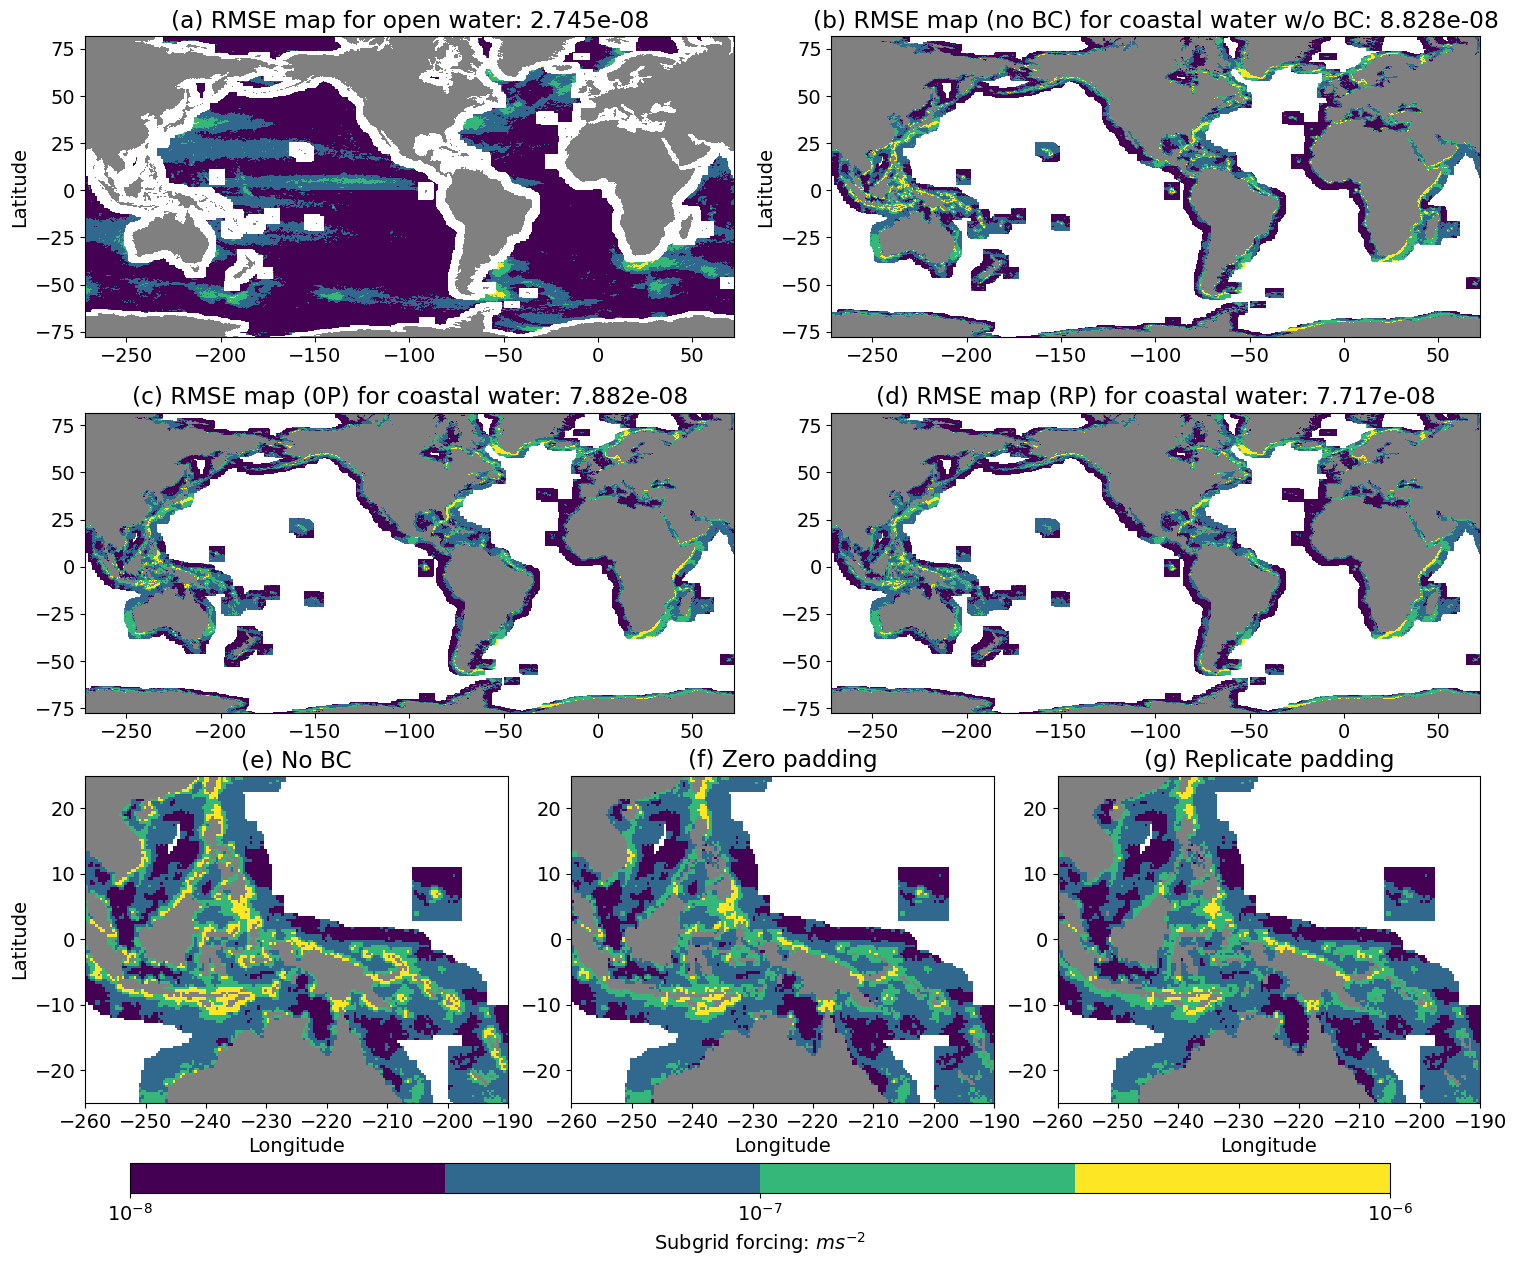

In [7]:
fig = plt.figure(figsize=(18, 15))
plt.rcParams.update({'font.size': 14})

# create subplots
outer_grid = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.15)

upper_grid = outer_grid[0].subgridspec(1, 2, wspace=0.15)
ax1 = fig.add_subplot(upper_grid[0, 0])
ax2 = fig.add_subplot(upper_grid[0, 1])

middle_grid = outer_grid[1].subgridspec(1, 2, wspace=0.15)
ax3 = fig.add_subplot(middle_grid[0, 0])
ax4 = fig.add_subplot(middle_grid[0, 1])

lower_grid = outer_grid[2].subgridspec(1, 3, wspace=0.15)
ax5 = fig.add_subplot(lower_grid[0, 0])
ax6 = fig.add_subplot(lower_grid[0, 1])
ax7 = fig.add_subplot(lower_grid[0, 2])

#zoom in region
# xlim=[-97,-60]
# ylim=[20,50]
xlim=[-260,-190]
ylim=[-25,25]


# load data
mask1=dataset.isel(time=0)['landmask'].values
mask=landmask.isel(time=0)['landmask'].values
S_test1 = test1['S_x']*(1e-7)*mask1
S_test2 = test2['S_x']*(1e-7)*mask1
S_test3 = test3['S_x']*(1e-7)*mask1
S_true = low_rez['S_x']*dataset.isel(time=0)['landmask']

# create discrete Colormap  
vmin, vmax, interval = -8, -6, 0.5
levels = np.arange(vmin, vmax + interval, interval)
cmap0 = plt.get_cmap('viridis', len(levels) - 1)  # Get a colormap with enough colors
norm0 = mcolors.BoundaryNorm(levels, ncolors=cmap0.N, clip=True)

#Open water RMSE
maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)
xq = test1['xu_ocean']
yq = test1['yu_ocean']

RMSE_OW = np.sqrt(((S_test1 *maskn - S_true*maskn)**2).mean(dim='time'))
RMSE_OW = np.where(RMSE_OW == 0, 1e-30, RMSE_OW)
RMSE_OW_local = float(np.nanmean(RMSE_OW))
p = ax1.pcolormesh(xq,yq,np.log10(RMSE_OW), cmap=cmap0, norm=norm0)
    # vmin=-9, vmax = -6)

# create Colormap for landmask
colors = [ "gray","none"] 
cmap = mcolors.ListedColormap(colors)
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# use pcolormesh for landmask
landmask_plot = ax1.pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
# ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_aspect('equal')
ax1.set_title('(a) RMSE map for open water:'+f' {RMSE_OW_local:.3e}')
ax1.set_xlim(xq[20],xq[-20])
ax1.set_ylim(yq[20],yq[-20])

#Coastal water RMSE without BC
maskn=np.where(mask == 1, torch.tensor(float('nan')), 1)
mask1n=np.where(mask1 == 0, torch.tensor(float('nan')), mask1)
maskn = mask1n*maskn

RMSE_CW = np.sqrt(((S_test1 *maskn - S_true*maskn)**2).mean(dim='time'))
RMSE_CW = np.where(RMSE_CW == 0, 1e-30, RMSE_CW)
RMSE_CW_local = float(np.nanmean(RMSE_CW))
p = ax2.pcolormesh(xq,yq,np.log10(RMSE_CW), cmap=cmap0, norm=norm0)
    # vmin=-9, vmax = -6)

# use pcolormesh for landmask
landmask_plot = ax2.pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
ax2.set_aspect('equal')
# ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('(b) RMSE map (no BC) for coastal water w/o BC:'+f' {RMSE_CW_local:.3e}')
ax2.set_xlim(xq[20],xq[-20])
ax2.set_ylim(yq[20],yq[-20])

# Zoom in
p = ax5.pcolormesh(xq,yq,np.log10(RMSE_CW), cmap=cmap0, norm=norm0)
    # vmin=-9, vmax = -6)
ax5.pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
ax5.set_xlabel('Longitude')
ax5.set_ylabel('Latitude')
ax5.set_title('(e) No BC')
ax5.set_xlim(xlim[0],xlim[1])
ax5.set_ylim(ylim[0],ylim[1])


#Coastal water RMSE with OP
maskn=np.where(mask == 1, torch.tensor(float('nan')), 1)
mask1n=np.where(mask1 == 0, torch.tensor(float('nan')), mask1)
maskn = mask1n*maskn

RMSE_CW = np.sqrt(((S_test2 *maskn - S_true*maskn)**2).mean(dim='time'))
RMSE_CW = np.where(RMSE_CW == 0, 1e-30, RMSE_CW)
RMSE_CW_local = float(np.nanmean(RMSE_CW))
p = ax3.pcolormesh(xq,yq,np.log10(RMSE_CW), cmap=cmap0, norm=norm0)
    # vmin=-9, vmax = -6)

# use pcolormesh for landmask
landmask_plot = ax3.pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
ax3.set_aspect('equal')
# ax3.set_xlabel('Longitude')
# ax3.set_ylabel('Latitude')
ax3.set_title('(c) RMSE map (0P) for coastal water:'+f' {RMSE_CW_local:.3e}')
ax3.set_xlim(xq[20],xq[-20])
ax3.set_ylim(yq[20],yq[-20])

# Zoom in
p = ax6.pcolormesh(xq,yq,np.log10(RMSE_CW), cmap=cmap0, norm=norm0)
    # vmin=-9, vmax = -6)
ax6.pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
ax6.set_xlabel('Longitude')
ax6.set_title('(f) Zero padding')
ax6.set_xlim(xlim[0],xlim[1])
ax6.set_ylim(ylim[0],ylim[1])


#Coastal water RMSE with RP
maskn=np.where(mask == 1, torch.tensor(float('nan')), 1)
mask1n=np.where(mask1 == 0, torch.tensor(float('nan')), mask1)
maskn = mask1n*maskn

RMSE_CW = np.sqrt(((S_test3 *maskn - S_true*maskn)**2).mean(dim='time'))
RMSE_CW = np.where(RMSE_CW == 0, 1e-30, RMSE_CW)
RMSE_CW_local = float(np.nanmean(RMSE_CW))
p = ax4.pcolormesh(xq,yq,np.log10(RMSE_CW), cmap=cmap0, norm=norm0)
    # vmin=-9, vmax = -6)

# use pcolormesh for landmask
landmask_plot = ax4.pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
ax4.set_aspect('equal')
# ax4.set_xlabel('Longitude')
ax4.set_title('(d) RMSE map (RP) for coastal water:'+f' {RMSE_CW_local:.3e}')
ax4.set_xlim(xq[20],xq[-20])
ax4.set_ylim(yq[20],yq[-20])

# Zoom in
p = ax7.pcolormesh(xq,yq,np.log10(RMSE_CW), cmap=cmap0, norm=norm0)
    # vmin=-9, vmax = -6)
ax7.pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
ax7.set_xlabel('Longitude')
ax7.set_title('(g) Replicate padding')
ax7.set_xlim(xlim[0],xlim[1])
ax7.set_ylim(ylim[0],ylim[1])

# colorbar
plt.subplots_adjust(bottom=0.16)
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02]) 
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal',ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
cbar.ax.set_xticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])

plt.savefig('../Paper_figures/figure3_1.png', dpi=300, bbox_inches="tight")

# Figure 3
Time-averaged global $RMSD^{(\mathrm{model})}$ maps of subgrid forcing $S_{x}^{(mean)}$ in the coastal domain between inference of the original CNN model GZ21 and the retrained CNN model GZ21-T2 without special BC treatment (a), with zero padding treatment (b) and replicate padding treatment (c).The MSE values in subtitles are the MSE averaged over both time and space.

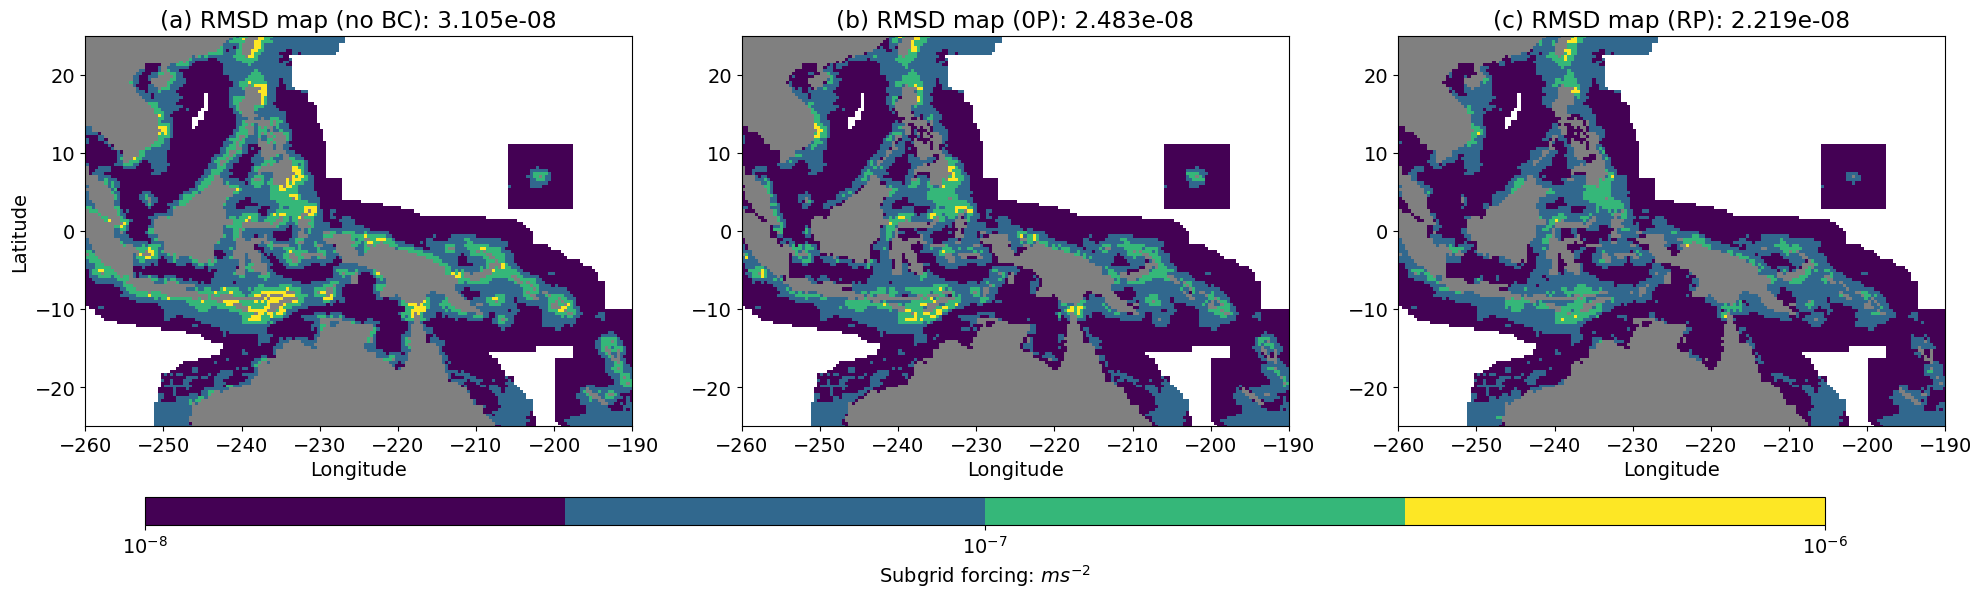

In [8]:
from matplotlib import patches 
def RMSD_timemean_diff_plt(test1_0,test2_0,test3_0,test1,test2,test3,mask, xlim=None, ylim=None,cbox1=None,cbox2=None):
    fig, ax = plt.subplots(1, 3, figsize=(24,7))
    plt.rcParams.update({'font.size': 14})
    mask1=dataset.isel(time=0)['landmask'].values
    S_test1 = test1['S_x']*(1e-7)*mask1
    S_test2 = test2['S_x']*(1e-7)*mask1
    S_test3 = test3['S_x']*(1e-7)*mask1
    S_test1_0 = test1_0['S_x']*(1e-7)*mask1
    S_test2_0 = test2_0['S_x']*(1e-7)*mask1
    S_test3_0 = test3_0['S_x']*(1e-7)*mask1
    # S_true = low_rez['S_x']

    xq = test1['xu_ocean']
    yq = test1['yu_ocean']

    # create discrete Colormap  
    vmin, vmax, interval = -8, -6, 0.5
    levels = np.arange(vmin, vmax + interval, interval)
    cmap0 = plt.get_cmap('viridis', len(levels) - 1)  # Get a colormap with enough colors
    norm0 = mcolors.BoundaryNorm(levels, ncolors=cmap0.N, clip=True)

    # create Colormap
    colors = [ "gray","none"] 
    cmap = mcolors.ListedColormap(colors)
    bounds = [0, 0.5, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)


    #Coastal water MSE
    maskn=np.where(mask == 1, torch.tensor(float('nan')), 1)
    mask1n=np.where(mask1 == 0, torch.tensor(float('nan')), mask1)
    maskn = mask1n*maskn

    MSE_CW1 = np.sqrt(((S_test1 *maskn - S_test1_0*maskn)**2).mean(dim='time'))
    MSE_CW1 = np.where(MSE_CW1 == 0, 1e-30, MSE_CW1)
    MSE_CW1_local = float(np.nanmean(MSE_CW1))
    p = ax[0].pcolormesh(xq,yq,np.log10(MSE_CW1), cmap=cmap0, norm=norm0)
        # vmin=-8, vmax = -6)
    # use pcolormesh for landmask
    ax[0].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')

    ax[0].set_xlabel('Longitude')
    ax[0].set_ylabel('Latitude')
    # cbar = fig.colorbar(p, ax=ax[0],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    # cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])
    
    ax[0].set_title('(a) RMSD map (no BC):'+f' {MSE_CW1_local:.3e}')
    ax[0].set_aspect('equal')

    if xlim is None:
        ax[0].set_xlim(xq[20],xq[-20])
        ax[0].set_ylim(yq[20],yq[-20])
    else:
        ax[0].set_xlim(xlim[0],xlim[1])
        ax[0].set_ylim(ylim[0],ylim[1])


    MSE_CW2 = np.sqrt(((S_test2 *maskn - S_test2_0*maskn)**2).mean(dim='time'))
    MSE_CW2 = np.where(MSE_CW2 == 0, 1e-30, MSE_CW2)
    MSE_CW2_local = float(np.nanmean(MSE_CW2))
    p = ax[1].pcolormesh(xq,yq,np.log10(MSE_CW2), cmap=cmap0, norm=norm0)
        # vmin=-8, vmax = -6)
    
    # use pcolormesh for landmask
    ax[1].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')

    ax[1].set_xlabel('Longitude')
    # ax[1].set_ylabel('Latitude')
    # cbar = fig.colorbar(p, ax=ax[1],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    # cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])
    
    ax[1].set_title('(b) RMSD map (0P):'+f' {MSE_CW2_local:.3e}')
    ax[1].set_aspect('equal')

    if xlim is None:
        ax[1].set_xlim(xq[20],xq[-20])
        ax[1].set_ylim(yq[20],yq[-20])
    else:
        ax[1].set_xlim(xlim[0],xlim[1])
        ax[1].set_ylim(ylim[0],ylim[1])
    

    MSE_CW3 = np.sqrt(((S_test3 *maskn - S_test3_0*maskn)**2).mean(dim='time'))
    MSE_CW3 = np.where(MSE_CW3 == 0, 1e-30, MSE_CW3)
    MSE_CW3_local = float(np.nanmean(MSE_CW3))
    p = ax[2].pcolormesh(xq,yq,np.log10(MSE_CW3), cmap=cmap0, norm=norm0)
        # vmin=-8, vmax = -6)
    # use pcolormesh for landmask
    ax[2].pcolormesh(xq, yq, mask1, cmap=cmap, norm=norm, shading='auto')
    ax[2].set_xlabel('Longitude')
    # ax[2].set_ylabel('Latitude')
    # cbar = fig.colorbar(p, ax=ax[2],ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    # cbar.ax.set_yticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])
    
    ax[2].set_title('(c) RMSD map (RP):'+f' {MSE_CW3_local:.3e}')
    ax[2].set_aspect('equal')

    if xlim is None:
        ax[2].set_xlim(xq[20],xq[-20])
        ax[2].set_ylim(yq[20],yq[-20])
    else:
        ax[2].set_xlim(xlim[0],xlim[1])
        ax[2].set_ylim(ylim[0],ylim[1])

    # colorbar
    plt.subplots_adjust(bottom=0.16)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.04]) 
    cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal',ticks=[-8, -7, -6], label='Subgrid forcing: $ms^{-2}$')
    cbar.ax.set_xticklabels(['$10^{-8}$', '$10^{-7}$', '$10^{-6}$'])


RMSD_timemean_diff_plt(test1_0,test2_0,test3_0,test1,test2,test3,mask=landmask.isel(time=0)['landmask'].values,xlim=[-260,-190], ylim=[-25,25])
# xlim=[-97,-60]
# ylim=[20,50]
plt.savefig('../Paper_figures/figure3_2.png', dpi=300, bbox_inches="tight")

# Figure 4
Time-averaged global $R^2$ maps for GZ21 inference of subgrid forcing $S_{x}^{(mean)}$ in the coastal domain without special BC treatment (a), with zero padding treatment (b) and replicate padding treatment (c).
(d) to (f) are zoom-in maps of (a) to (c), respectively.
The $R^2$ values in subtitles are the $R^2$ averaged over both time and space.
Red dots in (d) to (g) indicate a location near Atlantic City, New Jersey.

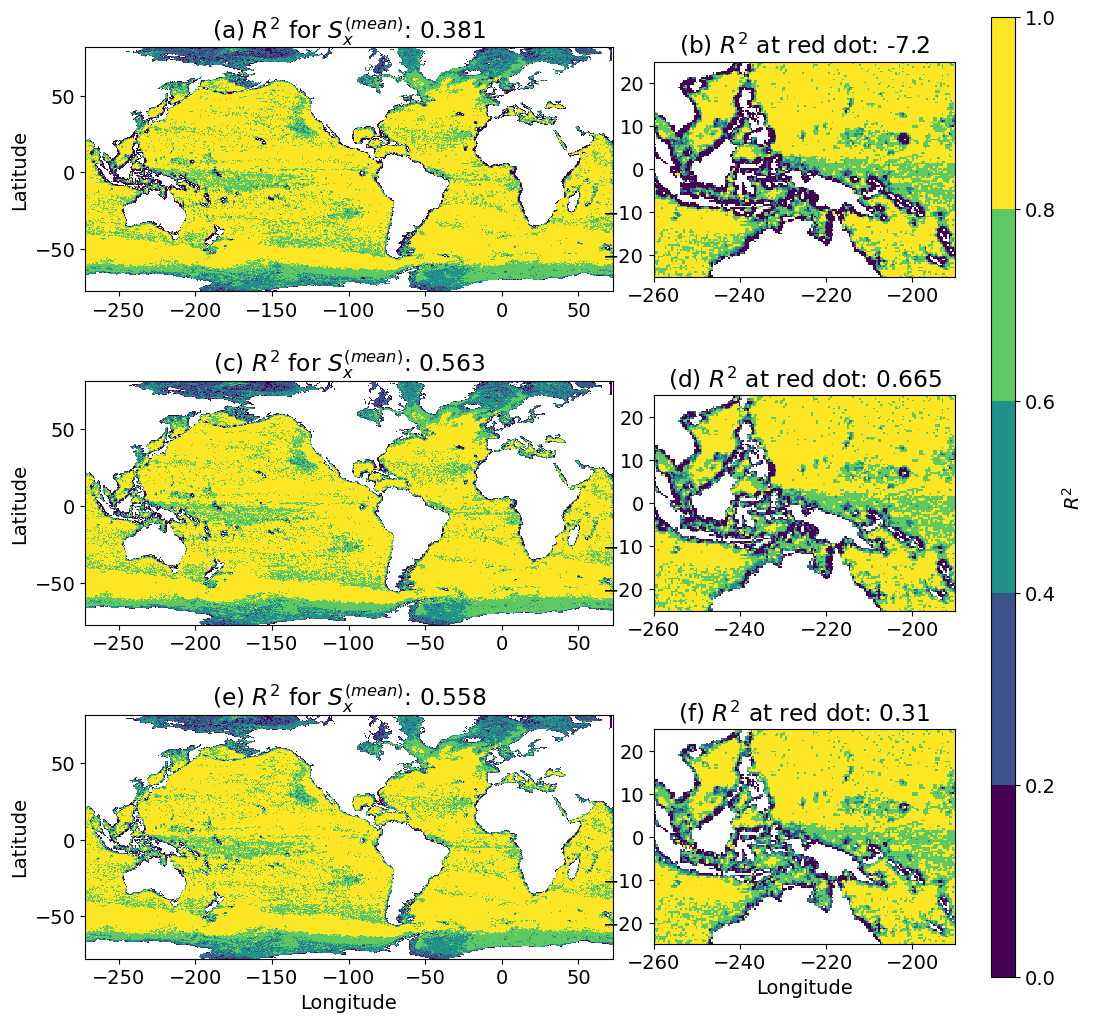

In [9]:
fig = plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size': 14})
# xlim=[-97,-60]
# ylim=[20,50]
xlim=[-260,-190]
ylim=[-25,25]

outer_grid = fig.add_gridspec(3, 2, width_ratios=[1.75, 1], hspace=0.3, wspace=0.1)
left_grid = outer_grid[:, 0].subgridspec(3, 1, hspace=0.3)
right_grid = outer_grid[:, 1].subgridspec(3, 1, hspace=0.3)

ax1 = fig.add_subplot(left_grid[0, 0])
ax2 = fig.add_subplot(left_grid[1, 0])
ax3 = fig.add_subplot(left_grid[2, 0])
ax4 = fig.add_subplot(right_grid[0, 0])
ax5 = fig.add_subplot(right_grid[1, 0])
ax6 = fig.add_subplot(right_grid[2, 0])

# Define the colorbar with discrete intervals
vmin, vmax, interval = 0, 1, 0.2
levels = np.arange(vmin, vmax + interval, interval)
cmap = plt.get_cmap('viridis', len(levels) - 1)  # Get a colormap with enough colors
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

mask=dataset.isel(time=0)['landmask'].values
maskn=np.where(mask == 0, torch.tensor(float('nan')), mask)
mse = dict()
variance = dict()
r_squared = dict()
R2_global = dict()
var = 'S_x'
mse[var] = ((test1[var]*maskn - low_rez[var]*1e7*maskn)**2).mean(dim='time')
variance[var] = ((low_rez[var]*1e7*maskn)**2).mean(dim='time')
r_squared[var] = 1 - mse[var] / variance[var]
R2_global[var] = 1 - np.nanmean(mse[var]) / np.nanmean(variance[var])
from matplotlib.patches import Arrow, Circle
xq = test1['xu_ocean']
yq = test1['yu_ocean']

im = ax1.pcolormesh(xq,yq,r_squared[var], cmap=cmap, norm=norm)
ax1.set_xlim(xq[20],xq[-20])
ax1.set_ylim(yq[20],yq[-20])
ax1.set_title('(a) $R^2$ for $S_{x}^{(mean)}$:'+f' {round(R2_global[var],3)}')
ax1.set_ylabel('Latitude')
# ax[0].set_xlabel('Longitude')
ax1.set_aspect('equal')

im = ax4.pcolormesh(xq,yq,r_squared[var], cmap=cmap, norm=norm)
ax4.set_xlim(xlim[0],xlim[1])
ax4.set_ylim(ylim[0],ylim[1])
patches = [Circle((-74.15, 39.41), radius=0.4, color='red')]
for patch in patches:
    im.axes.add_patch(patch)
R2_value=r_squared[var].isel(xu_ocean=514, yu_ocean=418).values.item()
ax4.set_title('(b) $R^2$ at red dot:'+f' {round(R2_value,3)}')
ax4.set_aspect('equal')


mse = dict()
variance = dict()
r_squared = dict()
R2_global = dict()
mse[var] = ((test2[var]*maskn - low_rez[var]*1e7*maskn)**2).mean(dim='time')
variance[var] = ((low_rez[var]*1e7*maskn)**2).mean(dim='time')
r_squared[var] = 1 - mse[var] / variance[var]
R2_global[var] = 1 - np.nanmean(mse[var]) / np.nanmean(variance[var])

im = ax2.pcolormesh(xq,yq,r_squared[var], cmap=cmap, norm=norm)
ax2.set_xlim(xq[20],xq[-20])
ax2.set_ylim(yq[20],yq[-20])
ax2.set_title('(c) $R^2$ for $S_{x}^{(mean)}$:'+f' {round(R2_global[var],3)}')
ax2.set_ylabel('Latitude')
ax2.set_aspect('equal')

im = ax5.pcolormesh(xq,yq,r_squared[var], cmap=cmap, norm=norm)
ax5.set_xlim(xlim[0],xlim[1])
ax5.set_ylim(ylim[0],ylim[1])
patches = [Circle((-74.15, 39.41), radius=0.4, color='red')]
for patch in patches:
    im.axes.add_patch(patch)
R2_value=r_squared[var].isel(xu_ocean=514, yu_ocean=418).values.item()
ax5.set_title('(d) $R^2$ at red dot:'+f' {round(R2_value,3)}')
ax5.set_aspect('equal')


mse = dict()
variance = dict()
r_squared = dict()
R2_global = dict()
mse[var] = ((test3[var]*maskn - low_rez[var]*1e7*maskn)**2).mean(dim='time')
variance[var] = ((low_rez[var]*1e7*maskn)**2).mean(dim='time')
r_squared[var] = 1 - mse[var] / variance[var]
R2_global[var] = 1 - np.nanmean(mse[var]) / np.nanmean(variance[var])

im = ax3.pcolormesh(xq,yq,r_squared[var], cmap=cmap, norm=norm)
ax3.set_xlim(xq[20],xq[-20])
ax3.set_ylim(yq[20],yq[-20])
ax3.set_title('(e) $R^2$ for $S_{x}^{(mean)}$:'+f' {round(R2_global[var],3)}')
ax3.set_ylabel('Latitude')
ax3.set_xlabel('Longitude')
ax3.set_aspect('equal')

im = ax6.pcolormesh(xq,yq,r_squared[var], cmap=cmap, norm=norm)
ax6.set_xlim(xlim[0],xlim[1])
ax6.set_ylim(ylim[0],ylim[1])
patches = [Circle((-74.15, 39.41), radius=0.4, color='red')]
for patch in patches:
    im.axes.add_patch(patch)
R2_value=r_squared[var].isel(xu_ocean=514, yu_ocean=418).values.item()
ax6.set_title('(f) $R^2$ at red dot:'+f' {round(R2_value,3)}')
ax6.set_xlabel('Longitude')
ax6.set_aspect('equal')


fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax, label=r'$R^2$')

plt.savefig('../Paper_figures/figure3_3.png', dpi=300, bbox_inches="tight")

# Figure 5
Time series of true forcing (blue), of the mean predictions ($S_{x}^{(mean)}$, orange), and of the 95\% confidence interval
($\pm 1.96 \, S_{x,i,j}^{(std)}$, dashed green) at the location indicated by the red dot in Figure \ref{fig3_3}.

514   418
-74.15000000000491 39.41411345672876


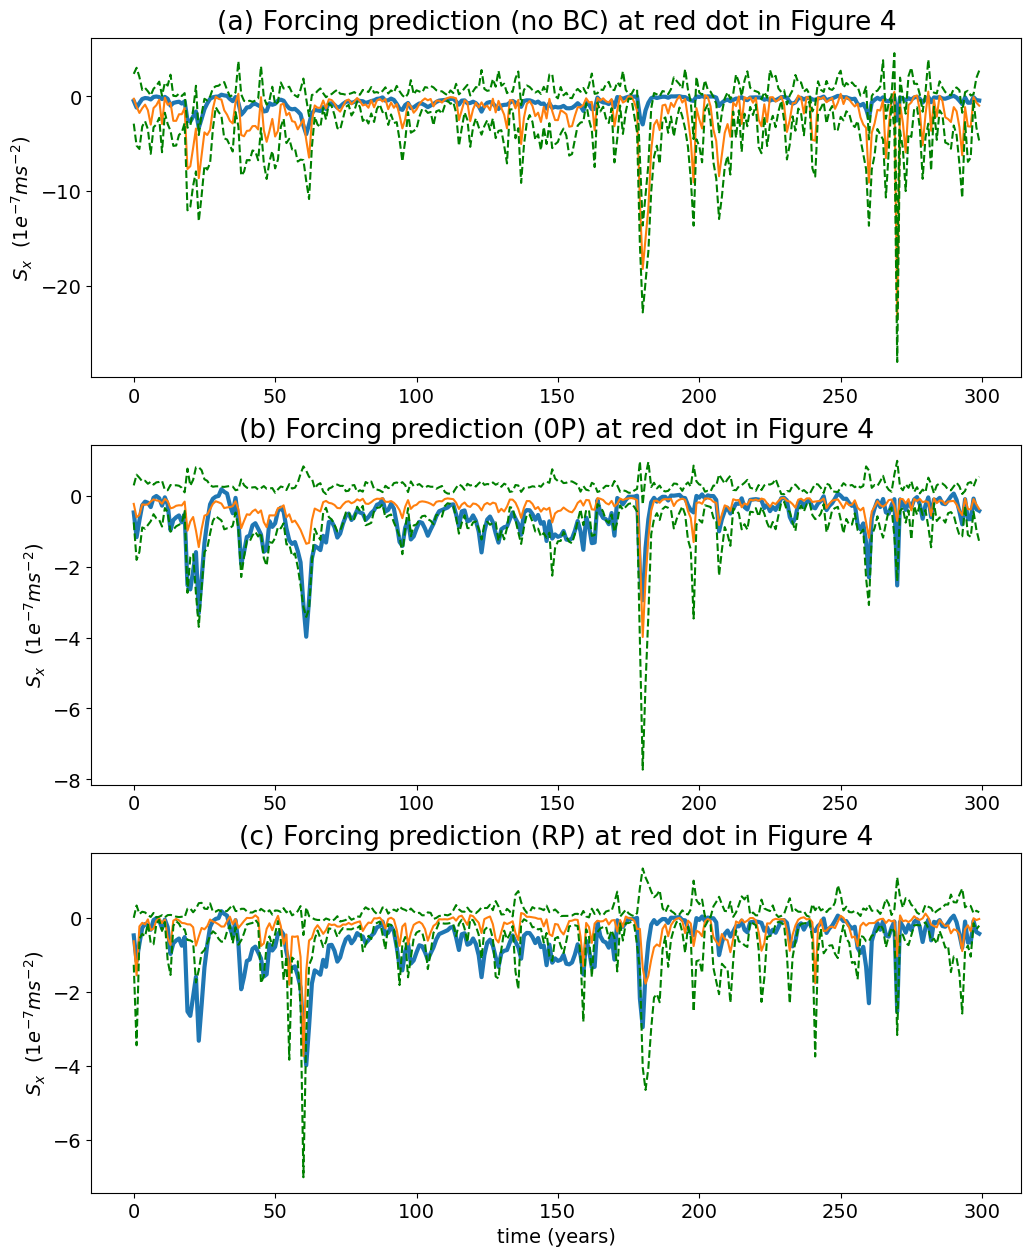

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(12,15))
plt.rcParams.update({'font.size': 16})

lon=-74.15
lat=39.41
# lon=-239.3
# lat=14.56

x = np.abs(low_rez.xu_ocean - lon).argmin().item()
y = np.abs(low_rez.yu_ocean - lat).argmin().item()
s = (100, 400) 
print(x, ' ', y)
print(low_rez.xu_ocean[x].values,low_rez.yu_ocean[y].values)
var = 'S_x'

ax[0].plot(low_rez[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))*1e7, linewidth=3)
ax[0].plot(test1[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
ub = (test1[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))
      + 1.96 / test1[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
lb = (test1[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
      - 1.96 / test1[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
ax[0].plot(ub, '--g')
ax[0].plot(lb, '--g')
ax[0].set_title('(a) Forcing prediction (no BC) at red dot in Figure 4')
ax[0].set_ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')


ax[1].plot(low_rez[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))*1e7, linewidth=3)
ax[1].plot(test2[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
ub = (test2[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))
      + 1.96 / test2[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
lb = (test2[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
      - 1.96 / test2[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
ax[1].plot(ub, '--g')
ax[1].plot(lb, '--g')
ax[1].set_title('(b) Forcing prediction (0P) at red dot in Figure 4')
ax[1].set_ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')


ax[2].plot(low_rez[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))*1e7, linewidth=3)
ax[2].plot(test3[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
ub = (test3[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))
      + 1.96 / test3[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
lb = (test3[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
      - 1.96 / test3[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
ax[2].plot(ub, '--g')
ax[2].plot(lb, '--g')
ax[2].set_xlabel('time (years)')
ax[2].set_title('(c) Forcing prediction (RP) at red dot in Figure 4')
ax[2].set_ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')

plt.savefig('../Paper_figures/figure3_4.png', dpi=300, bbox_inches="tight")

514   418
-74.15000000000491 39.41411345672876


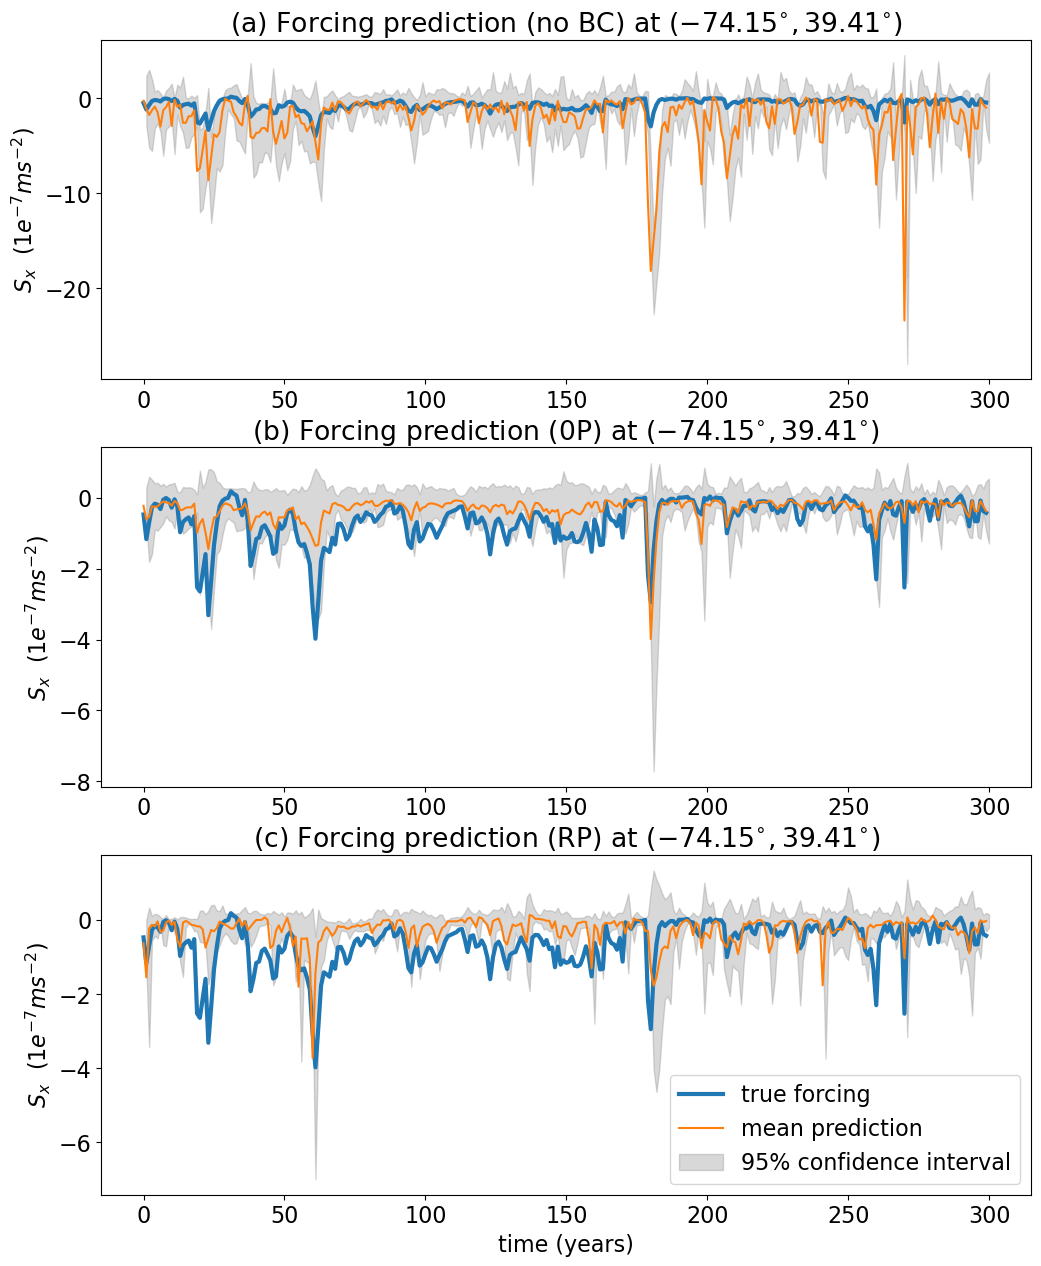

In [27]:
fig, ax = plt.subplots(3, 1, figsize=(12,15))
plt.rcParams.update({'font.size': 16})

lon=-74.15
lat=39.41
# lon=-239.3
# lat=14.56

x = np.abs(low_rez.xu_ocean - lon).argmin().item()
y = np.abs(low_rez.yu_ocean - lat).argmin().item()
s = (100, 400) 
# times = np.linspace(s[0], s[1], s[1] - s[0])
times = np.linspace(1,s[1] - s[0],s[1] - s[0])
print(x, ' ', y)
print(low_rez.xu_ocean[x].values,low_rez.yu_ocean[y].values)
var = 'S_x'

ax[0].plot(low_rez[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))*1e7, linewidth=3)
ax[0].plot(test1[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
ub = (test1[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))
      + 1.96 / test1[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
lb = (test1[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
      - 1.96 / test1[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
ax[0].fill_between(times, lb, ub, color='grey', alpha=0.3, label='95% CI')
ax[0].set_title('(a) Forcing prediction (no BC) at $(-74.15^{\circ},39.41^{\circ})$')
ax[0].set_ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')


ax[1].plot(low_rez[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))*1e7, linewidth=3)
ax[1].plot(test2[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
ub = (test2[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))
      + 1.96 / test2[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
lb = (test2[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
      - 1.96 / test2[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
ax[1].fill_between(times, lb, ub, color='grey', alpha=0.3, label='95% CI')
ax[1].set_title('(b) Forcing prediction (0P) at $(-74.15^{\circ},39.41^{\circ})$')
ax[1].set_ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')


ax[2].plot(low_rez[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))*1e7, linewidth=3,label='true forcing')
ax[2].plot(test3[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])),label='mean prediction')
ub = (test3[var].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1]))
      + 1.96 / test3[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y,time=slice(s[0],s[1])))
lb = (test3[var].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1]))
      - 1.96 / test3[f'{var}scale'].isel(xu_ocean=x, yu_ocean=y, time=slice(s[0],s[1])))
ax[2].fill_between(times, lb, ub, color='grey', alpha=0.3,label='95% confidence interval')
ax[2].set_xlabel('time (years)')
ax[2].set_title('(c) Forcing prediction (RP) at $(-74.15^{\circ},39.41^{\circ})$')
ax[2].set_ylabel(fr'${var}$' + '  ' +  r'$(1e^{-7}ms^{-2}$)')
ax[2].legend(loc='lower right')

plt.savefig('../Paper_figures/figure3_4.png', dpi=300, bbox_inches="tight")

# Load for online implementations

In [2]:
import sys
your_library_path = "/scratch/cimes/cz3321/MOM6/experiments/double_gyre/postprocess/helpers"
sys.path.insert(0, your_library_path)
from dataset_paper import dataset_experiments

In [4]:
common_folder = '/scratch/cimes/cz3321/MOM6/MOM6-examples/ocean_only/double_gyre/'
exps = ('R32','R4_GZ_ARTHUR','R4_GZ_ARTHUR_0P','R4_GZ_ARTHUR_BC',
        'R4_GZ_4regions_test1','R4_GZ_4regions_test1_BC',
        'R4_GZ_4regions_test2','R4_GZ_4regions_test2_0P','R4_GZ_4regions_test2_BC',
        'R4_GZ_4regions_test3','R4_GZ_4regions_test3_0P','R4_GZ_4regions_test3_BC',
        'R4_GZ_4regions_test4','R4_GZ_4regions_test4_0P','R4_GZ_4regions_test4_BC','R4_GZ_4regions_test4_0P2',
        'R4_GZ_4regions_test5','R4_GZ_4regions_test5_0P','R4_GZ_4regions_test5_BC',
        'R4_GZ_4regions_test6','R4_GZ_4regions_test6_0P','R4_GZ_4regions_test6_BC',
        'R4_GZ_4regions_test7','R4_GZ_4regions_test7_0P','R4_GZ_4regions_test7_BC',
        'R4_GZ_4regions_test8','R4_GZ_4regions_test8_0P','R4_GZ_4regions_test8_BC',
        'R32_CBOX','R4_GZ_CBOX','R4_GZ_CBOX_BC_0P','R4_GZ_CBOX_BC')

In [5]:
ds2 = dataset_experiments(common_folder, exps)

In [5]:
ds2.names['R32'] = 'Ground truth: C1'
ds2.names['R4_GZ_ARTHUR'] = 'R4-P: C1'
ds2.names['R32_CBOX'] = 'Ground truth: C2'
ds2.names['R4_GZ_CBOX'] = 'R4-P: C2'

# Figure 7
Snapshots of the upper layer relative vorticity at the end of C1 and C2 simulations from the coarse resolution model with ML parameterizations R4-P (a,c) and the fine resolution R32 (b,d).
The ML parameterizations do not use special BC treatments.
The grey rectangle indicates the region where the unrealistic eddies are generated.

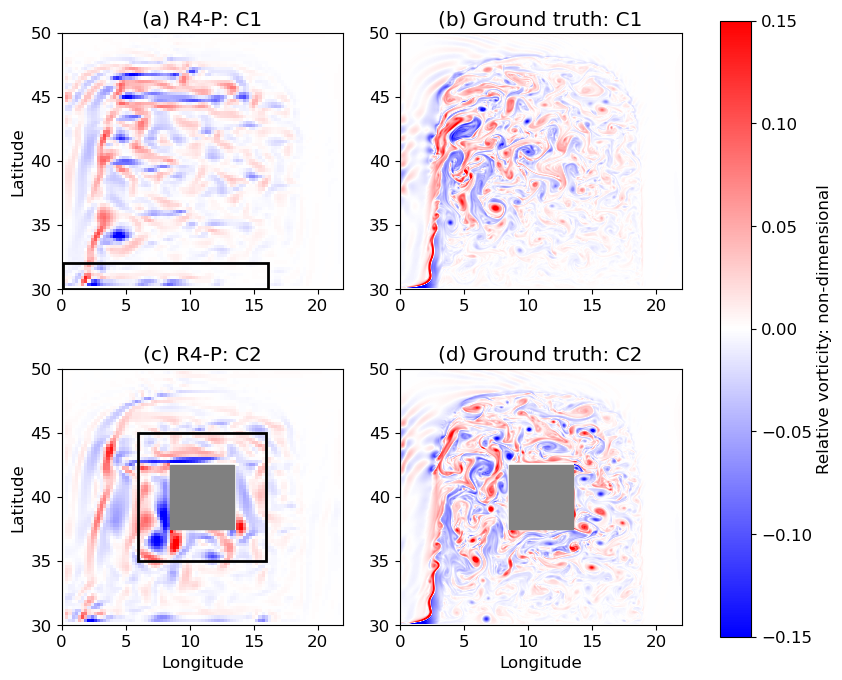

In [8]:
ds2.plot_relative_vorticity_snapshot(('R4_GZ_ARTHUR','R32','R4_GZ_CBOX','R32_CBOX'),Time=-10,sketch=True)

In [6]:
ds2.names['R32'] = 'Ground truth'
ds2.names['R4_GZ_ARTHUR'] = 'No padding'
ds2.names['R4_GZ_ARTHUR_0P'] = 'Zero padding'
ds2.names['R4_GZ_ARTHUR_BC'] = 'Replicate padding'
ds2.names['R32_CBOX'] = 'Ground truth'
ds2.names['R4_GZ_CBOX'] = 'No padding'
ds2.names['R4_GZ_CBOX_BC_0P'] = 'Zero padding'
ds2.names['R4_GZ_CBOX_BC'] = 'Replicate padding'
ds2.names['R4_GZ_4regions_test2'] = 'No padding'
ds2.names['R4_GZ_4regions_test2_0P'] = 'Zero padding'
ds2.names['R4_GZ_4regions_test2_BC'] = 'Replicate padding'

# Figure 8-10
(a)-(d): Snapshots of the upper layer relative vorticity at the end of C1 simulations from: (a) the fine resolution R32; (b) the coarse resolution model using ML parameterization R4-P without special BC treatment; (c) with zero padding strategy; or (d) with replicate padding.
(e) \& (f): Comparison of KE time series for the flow upper layer and lower layer between the four simulations from (a) to (d).
The dashed lines are the time-mean values of KE over the last 5 years and the colors of solid lines correspond to the edge colors of plots (a) to (d), where blue is for ground truth, orange for no padding, green for zero padding and red for replicate padding.

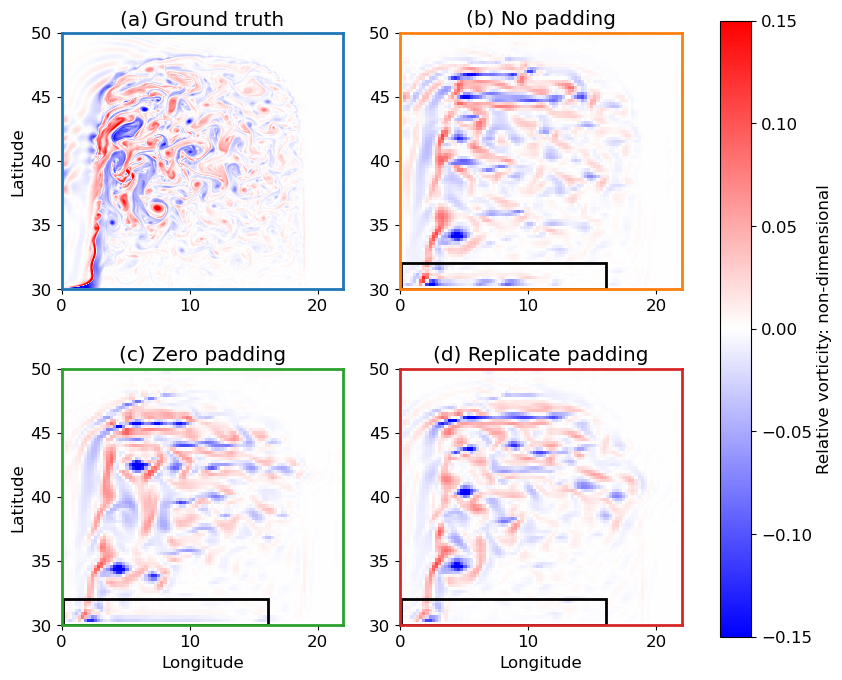

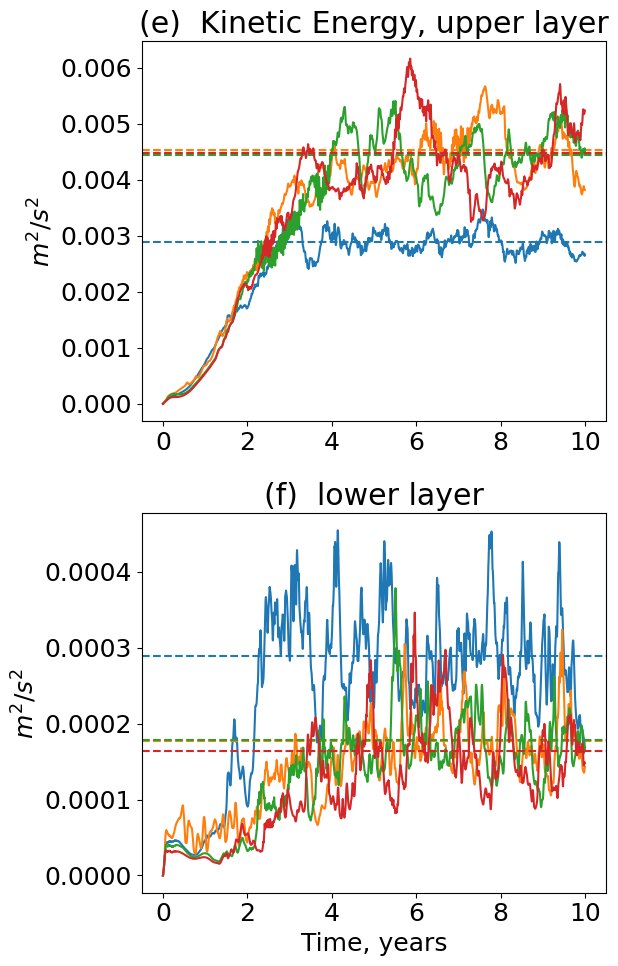

In [7]:
#8
ds2.plot_relative_vorticity_snapshot(('R32','R4_GZ_ARTHUR','R4_GZ_ARTHUR_0P','R4_GZ_ARTHUR_BC'),Time=-10,set_color=True,borderrect=True,borderrect_no=[2,3,4])
ds2.plot_KE(('R32','R4_GZ_ARTHUR','R4_GZ_ARTHUR_0P','R4_GZ_ARTHUR_BC'),legendsize='none',alphabet_a=101)

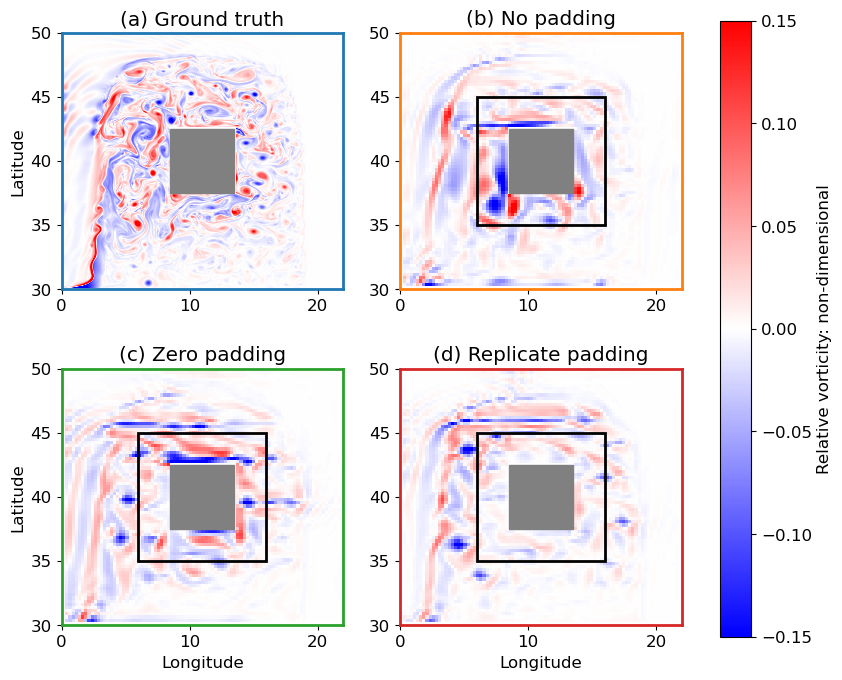

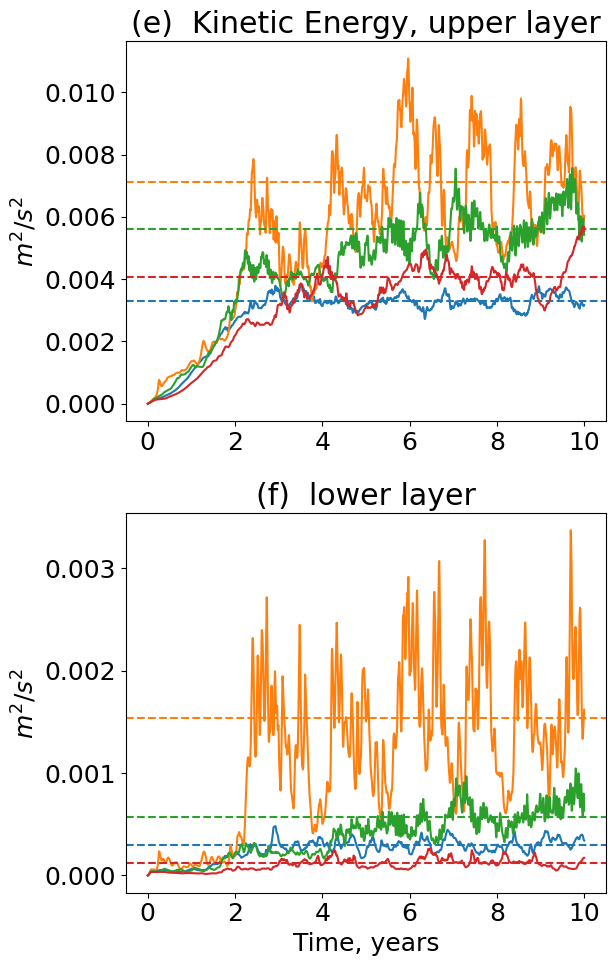

In [8]:
#9
ds2.plot_relative_vorticity_snapshot(('R32_CBOX','R4_GZ_CBOX','R4_GZ_CBOX_BC_0P','R4_GZ_CBOX_BC'),Time=-10,set_color=True,cbox=True,centrect=True,centrect_no=[2,3,4])
ds2.plot_KE(('R32_CBOX','R4_GZ_CBOX','R4_GZ_CBOX_BC_0P','R4_GZ_CBOX_BC'),legendsize='none',alphabet_a=101)

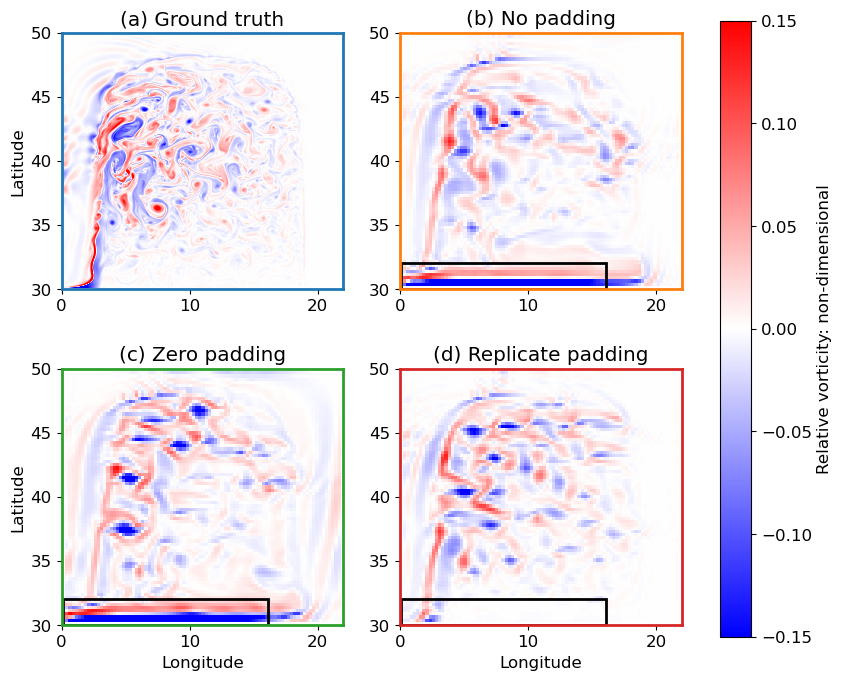

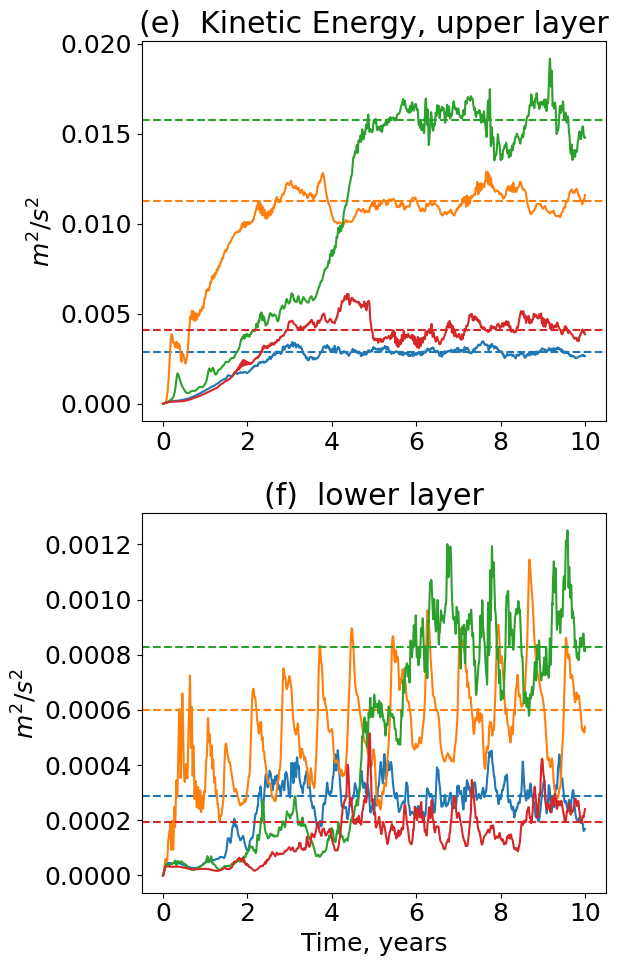

In [9]:
#10
ds2.plot_relative_vorticity_snapshot(('R32','R4_GZ_4regions_test2','R4_GZ_4regions_test2_0P','R4_GZ_4regions_test2_BC'),Time=-10,set_color=True,borderrect=True,borderrect_no=[2,3,4])
ds2.plot_KE(('R32','R4_GZ_4regions_test2','R4_GZ_4regions_test2_0P','R4_GZ_4regions_test2_BC'),legendsize='none',alphabet_a=101)

# Figure 11
Comparison of KE time series for the flow upper layer and lower layer between the simulations using GZ21 and retrained CNN models.
The first column of plots (a) and (b) represent the simulation results without any BC treatment, the second column of plots (c) and (d) represent the results with zero padding BC treatment, and the third column of plots (e) and (f) represent the results with replicate padding BC treatment.
The dashed lines are the time-mean values of KE over the last 5 years and each row shares the same axis range to better compare the results with different BC strategies.

In [13]:
ds2.names['R32'] = 'Ground truth'
ds2.names['R4_GZ_ARTHUR'] = 'GZ21'
ds2.names['R4_GZ_4regions_test1'] = 'GZ21-T1'
ds2.names['R4_GZ_4regions_test2'] = 'GZ21-T2'
ds2.names['R4_GZ_4regions_test3'] = 'GZ21-T3'
ds2.names['R4_GZ_4regions_test4'] = 'GZ21-T4'
ds2.names['R4_GZ_4regions_test5'] = 'GZ21-T5'
ds2.names['R4_GZ_4regions_test6'] = 'GZ21-T6'
ds2.names['R4_GZ_4regions_test7'] = 'GZ21-T7'
ds2.names['R4_GZ_4regions_test8'] = 'GZ21-T8'
ds2.names['R4_GZ_ARTHUR_0P'] = 'GZ21'
ds2.names['R4_GZ_4regions_test1_0P'] = 'GZ21-T1'
ds2.names['R4_GZ_4regions_test2_0P'] = 'GZ21-T2'
ds2.names['R4_GZ_4regions_test3_0P'] = 'GZ21-T3'
ds2.names['R4_GZ_4regions_test4_0P'] = 'GZ21-T4'
ds2.names['R4_GZ_4regions_test5_0P'] = 'GZ21-T5'
ds2.names['R4_GZ_4regions_test6_0P'] = 'GZ21-T6'
ds2.names['R4_GZ_4regions_test7_0P'] = 'GZ21-T7'
ds2.names['R4_GZ_4regions_test8_0P'] = 'GZ21-T8'
ds2.names['R4_GZ_ARTHUR_BC'] = 'GZ21'
ds2.names['R4_GZ_4regions_test1_BC'] = 'GZ21-T1'
ds2.names['R4_GZ_4regions_test2_BC'] = 'GZ21-T2'
ds2.names['R4_GZ_4regions_test3_BC'] = 'GZ21-T3'
ds2.names['R4_GZ_4regions_test4_BC'] = 'GZ21-T4'
ds2.names['R4_GZ_4regions_test5_BC'] = 'GZ21-T5'
ds2.names['R4_GZ_4regions_test6_BC'] = 'GZ21-T6'
ds2.names['R4_GZ_4regions_test7_BC'] = 'GZ21-T7'
ds2.names['R4_GZ_4regions_test8_BC'] = 'GZ21-T8'

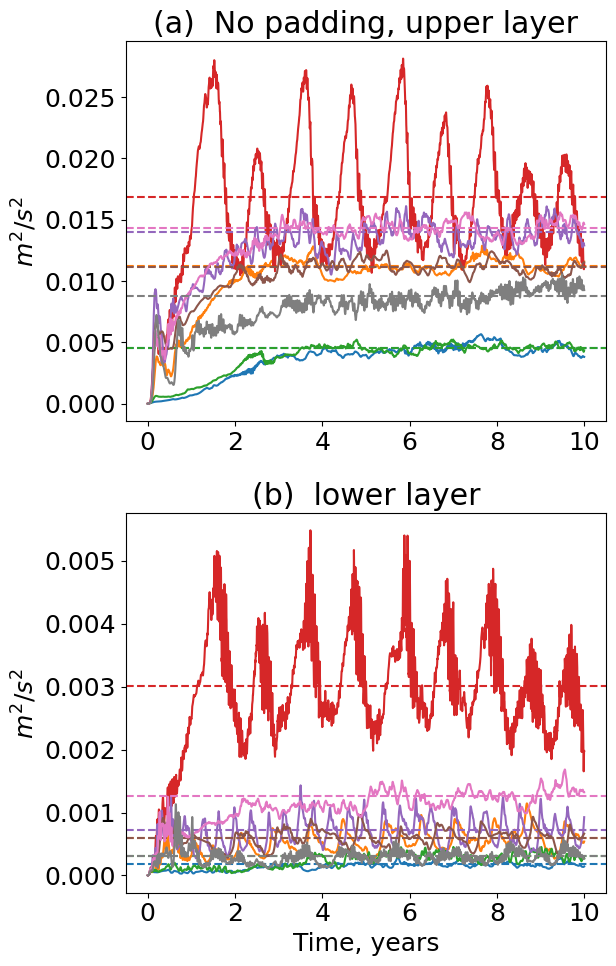

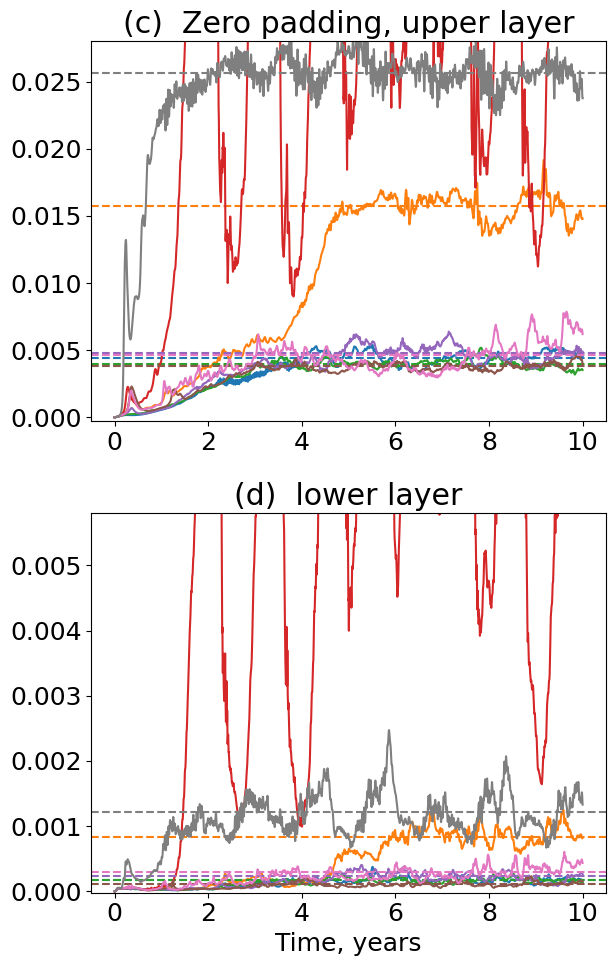

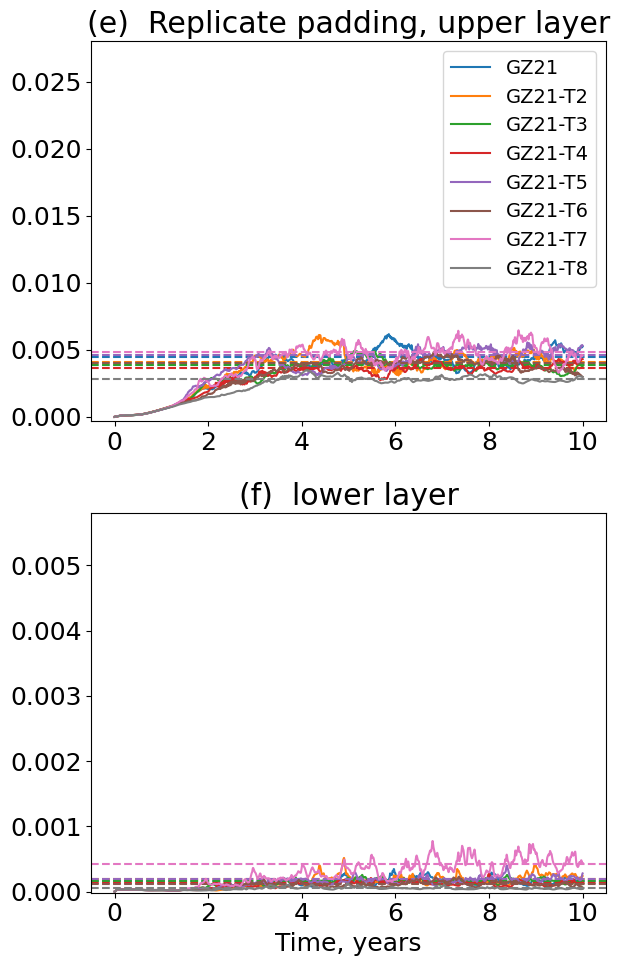

In [14]:
ds2.plot_KE(('R4_GZ_ARTHUR','R4_GZ_4regions_test2','R4_GZ_4regions_test3','R4_GZ_4regions_test4',
             'R4_GZ_4regions_test5','R4_GZ_4regions_test6','R4_GZ_4regions_test7','R4_GZ_4regions_test8'),legendsize='none',title='No padding')
ds2.plot_KE(('R4_GZ_ARTHUR_0P','R4_GZ_4regions_test2_0P','R4_GZ_4regions_test3_0P','R4_GZ_4regions_test4_0P',
                   'R4_GZ_4regions_test5_0P','R4_GZ_4regions_test6_0P','R4_GZ_4regions_test7_0P','R4_GZ_4regions_test8_0P'),ytop_up=0.028,ytop_lower=0.0058,legendsize='none',alphabet_a=99,yaxis=False,title='Zero padding')
ds2.plot_KE(('R4_GZ_ARTHUR_BC','R4_GZ_4regions_test2_BC','R4_GZ_4regions_test3_BC','R4_GZ_4regions_test4_BC',
                   'R4_GZ_4regions_test5_BC','R4_GZ_4regions_test6_BC','R4_GZ_4regions_test7_BC','R4_GZ_4regions_test8_BC'),ytop_up=0.028,ytop_lower=0.0058,alphabet_a=101,legendsize='small',yaxis=False,title='Replicate padding')